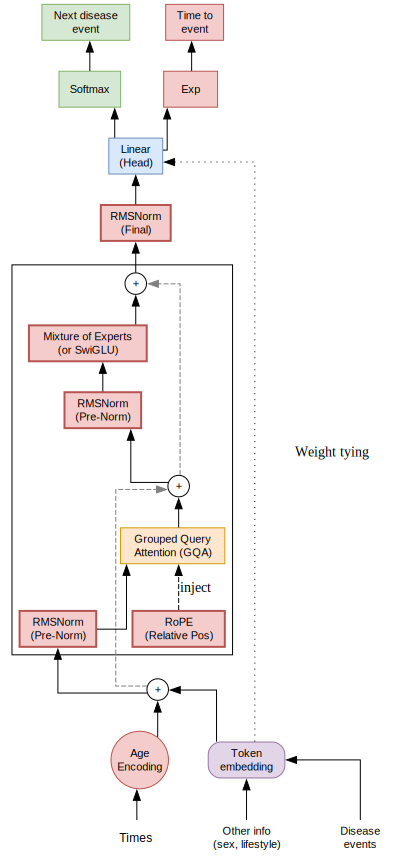

In [4]:
from graphviz import Digraph
    
# except ImportError:
#     !pip install graphviz

def draw_modern_delphi():
    
    dot = Digraph('ModernDelphi', comment='Modern Delphi Architecture')
    dot.attr(rankdir='BT')
    dot.attr(splines='ortho')
    dot.attr(nodesep='0.5', ranksep='0.4')
    dot.attr('node', fontname='Helvetica', fontsize='11')

    COLOR_RED_FILL = '#F4CCCC'
    COLOR_RED_LINE = '#B85450'
    COLOR_BLUE_FILL = '#DAE8FC'
    COLOR_BLUE_LINE = '#6C8EBF'
    COLOR_YELLOW_FILL = '#FFF2CC'
    COLOR_YELLOW_LINE = '#D6B656'
    COLOR_ORANGE_FILL = '#FFE6CC'
    COLOR_ORANGE_LINE = '#D79B00'
    COLOR_GREEN_FILL = '#D5E8D4'
    COLOR_GREEN_LINE = '#82B366'
    COLOR_PURPLE_FILL = '#E1D5E7'
    COLOR_PURPLE_LINE = '#9673A6'

    def node_new(name, label):
        
        dot.node(name, label, shape='box', style='filled', 
                 fillcolor=COLOR_RED_FILL, color=COLOR_RED_LINE, penwidth='2.0')

    def node_blue(name, label):
        
        dot.node(name, label, shape='box', style='filled', 
                 fillcolor=COLOR_BLUE_FILL, color=COLOR_BLUE_LINE)

    def node_yellow(name, label):

        dot.node(name, label, shape='box', style='filled,rounded', 
                 fillcolor=COLOR_YELLOW_FILL, color=COLOR_YELLOW_LINE)
    
    def node_orange(name, label):
        
        dot.node(name, label, shape='box', style='filled', 
                 fillcolor=COLOR_ORANGE_FILL, color=COLOR_ORANGE_LINE)

    def node_input(name, label, shape='plaintext'):
        dot.node(name, label, shape=shape, style='filled', 
                 fillcolor='#FFFFFF', color='#FFFFFF')

    # --- [구조 그리기 시작] ---

    # 1. Inputs & Embeddings
    # Times -> Age Encoding (논문의 붉은 원형 아이콘 스타일)
    with dot.subgraph(name='cluster_inputs') as c:
        c.attr(style='invis')
        dot.node('Times', 'Times', shape='plaintext', fontsize='12')
        dot.node('AgeEnc', 'Age\nEncoding', shape='circle', style='filled', 
                 fillcolor=COLOR_RED_FILL, color=COLOR_RED_LINE, width='0.8', fixedsize='true')
        
        dot.node('Other', 'Other info\n(sex, lifestyle)', shape='plaintext')
        dot.node('Disease', 'Disease\nevents', shape='plaintext')
        
        dot.node('TokEmb', 'Token\nembedding', shape='box', style='filled,rounded',
                 fillcolor=COLOR_PURPLE_FILL, color=COLOR_PURPLE_LINE)
        
        dot.node('Sum', '+', shape='circle', width='0.3', fixedsize='true')

    # 2. Main Transformer Block (Modern)
    with dot.subgraph(name='cluster_block') as c:
        # c.attr(label='N × Transformer Block (Modern)', style='rounded', color='black')
        
        # (1) Pre-Norm (New style: RMSNorm is visually distinct)
        node_new('RMS1', 'RMSNorm\n(Pre-Norm)')
        
        # (2) Attention (GQA) & RoPE
        node_orange('GQA', 'Grouped Query\nAttention (GQA)')
        node_new('RoPE', 'RoPE\n(Relative Pos)') # New Feature!
        
        # (3) Residual Add
        dot.node('Add1', '+', shape='circle', width='0.3', fixedsize='true')
        
        # (4) FFN / MoE
        node_new('RMS2', 'RMSNorm\n(Pre-Norm)')
        node_new('MoE', 'Mixture of Experts\n(or SwiGLU)') # New Feature!
        
        # (5) Residual Add
        dot.node('Add2', '+', shape='circle', width='0.3', fixedsize='true')

        # 내부 연결
        c.edge('RMS1', 'GQA')
        c.edge('RoPE', 'GQA', style='dashed', label='inject')
        c.edge('GQA', 'Add1')
        c.edge('Add1', 'RMS2')
        c.edge('RMS2', 'MoE')
        c.edge('MoE', 'Add2')

    # 3. Outputs
    node_new('RMSFinal', 'RMSNorm\n(Final)')
    node_blue('Linear', 'Linear\n(Head)')
    
    # Heads
    dot.node('Softmax', 'Softmax', shape='box', style='filled', 
             fillcolor=COLOR_GREEN_FILL, color=COLOR_GREEN_LINE)
    dot.node('Next', 'Next disease\nevent', shape='box', style='filled', 
             fillcolor=COLOR_GREEN_FILL, color=COLOR_GREEN_LINE)
    
    dot.node('Exp', 'Exp', shape='box', style='filled', 
             fillcolor=COLOR_RED_FILL, color=COLOR_RED_LINE)
    dot.node('TimeOut', 'Time to\nevent', shape='box', style='filled', 
             fillcolor=COLOR_RED_FILL, color=COLOR_RED_LINE)

    # --- [엣지(선) 연결] ---
    
    # Input Flow
    dot.edge('Times', 'AgeEnc')
    dot.edge('Other', 'TokEmb')
    dot.edge('Disease', 'TokEmb')
    dot.edge('AgeEnc', 'Sum')
    dot.edge('TokEmb', 'Sum')
    
    # Block Entry
    dot.edge('Sum', 'RMS1')
    dot.edge('Sum', 'Add1', style='dashed', color='gray') # Residual Skip
    dot.edge('Add1', 'Add2', style='dashed', color='gray') # Residual Skip
    
    # Block Exit
    dot.edge('Add2', 'RMSFinal')
    dot.edge('RMSFinal', 'Linear')
    
    # Output Heads
    dot.edge('Linear', 'Softmax')
    dot.edge('Softmax', 'Next')
    
    dot.edge('Linear', 'Exp')
    dot.edge('Exp', 'TimeOut')
    
    # Weight Tying (Dotted line from Linear back to Embedding)
    dot.edge('Linear', 'TokEmb', style='dotted', label='Weight tying', dir='back', constraint='false')

    return dot

# 실행 및 출력
diagram = draw_modern_delphi()
display(diagram)

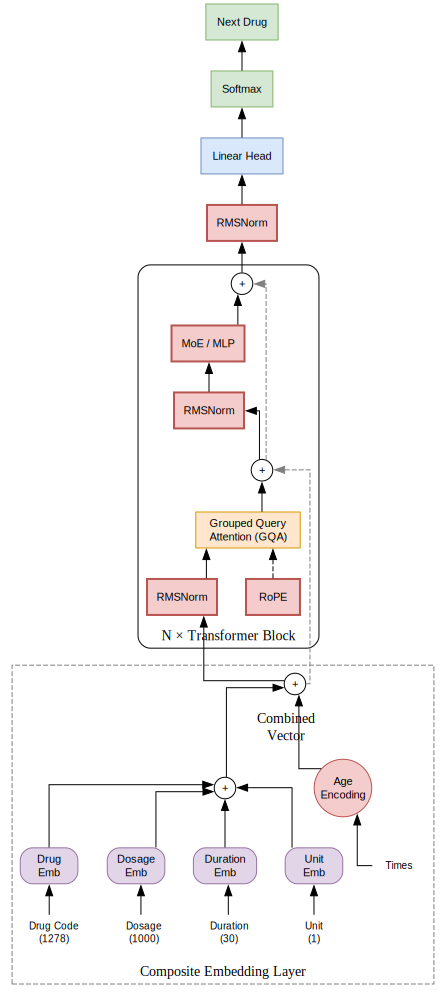

In [1]:
from graphviz import Digraph

def draw_modified_delphi():
    # 1. 스타일 설정
    dot = Digraph('ModifiedDelphi', comment='Modified Delphi Architecture with Composite Embeddings')
    dot.attr(rankdir='BT')  # Bottom to Top
    dot.attr(splines='ortho')
    dot.attr(nodesep='0.4', ranksep='0.4')
    dot.attr('node', fontname='Helvetica', fontsize='11')

    # 색상 팔레트
    COLOR_RED_FILL = '#F4CCCC'
    COLOR_RED_LINE = '#B85450'
    COLOR_BLUE_FILL = '#DAE8FC'
    COLOR_BLUE_LINE = '#6C8EBF'
    COLOR_YELLOW_FILL = '#FFF2CC'
    COLOR_YELLOW_LINE = '#D6B656'
    COLOR_ORANGE_FILL = '#FFE6CC'
    COLOR_ORANGE_LINE = '#D79B00'
    COLOR_GREEN_FILL = '#D5E8D4'
    COLOR_GREEN_LINE = '#82B366'
    COLOR_PURPLE_FILL = '#E1D5E7'
    COLOR_PURPLE_LINE = '#9673A6'

    # 노드 스타일 함수
    def node_new(name, label):
        dot.node(name, label, shape='box', style='filled', fillcolor=COLOR_RED_FILL, color=COLOR_RED_LINE, penwidth='2.0')

    def node_blue(name, label):
        dot.node(name, label, shape='box', style='filled', fillcolor=COLOR_BLUE_FILL, color=COLOR_BLUE_LINE)

    def node_orange(name, label):
        dot.node(name, label, shape='box', style='filled', fillcolor=COLOR_ORANGE_FILL, color=COLOR_ORANGE_LINE)

    # --- [구조 그리기] ---

    # 1. Inputs & Composite Embeddings (핵심 변경 구간)
    with dot.subgraph(name='cluster_inputs') as c:
        c.attr(style='dashed', label='Composite Embedding Layer', color='gray')
        
        # Inputs
        c.node('In_Drug', 'Drug Code\n(1278)', shape='plaintext', fontsize='10')
        c.node('In_Dose', 'Dosage\n(1000)', shape='plaintext', fontsize='10')
        c.node('In_Dur', 'Duration\n(30)', shape='plaintext', fontsize='10')
        c.node('In_Unit', 'Unit\n(1)', shape='plaintext', fontsize='10')
        
        # Embeddings (Split)
        c.node('Emb_Drug', 'Drug\nEmb', shape='box', style='filled,rounded', fillcolor=COLOR_PURPLE_FILL, color=COLOR_PURPLE_LINE, width='0.8')
        c.node('Emb_Dose', 'Dosage\nEmb', shape='box', style='filled,rounded', fillcolor=COLOR_PURPLE_FILL, color=COLOR_PURPLE_LINE, width='0.8')
        c.node('Emb_Dur', 'Duration\nEmb', shape='box', style='filled,rounded', fillcolor=COLOR_PURPLE_FILL, color=COLOR_PURPLE_LINE, width='0.8')
        c.node('Emb_Unit', 'Unit\nEmb', shape='box', style='filled,rounded', fillcolor=COLOR_PURPLE_FILL, color=COLOR_PURPLE_LINE, width='0.8')
        
        # Sum operation for Embeddings
        c.node('Sum_Emb', '+', shape='circle', width='0.3', fixedsize='true', style='filled', fillcolor='white')
        
        # Age Encoding (Existing)
        c.node('Times', 'Times', shape='plaintext', fontsize='10')
        c.node('AgeEnc', 'Age\nEncoding', shape='circle', style='filled', fillcolor=COLOR_RED_FILL, color=COLOR_RED_LINE, width='0.8', fixedsize='true')
        
        # Final Sum (Embeddings + Age)
        c.node('Sum_Final', '+', shape='circle', width='0.3', fixedsize='true')

        # Connections within Input Cluster
        c.edge('In_Drug', 'Emb_Drug')
        c.edge('In_Dose', 'Emb_Dose')
        c.edge('In_Dur', 'Emb_Dur')
        c.edge('In_Unit', 'Emb_Unit')
        
        c.edge('Emb_Drug', 'Sum_Emb')
        c.edge('Emb_Dose', 'Sum_Emb')
        c.edge('Emb_Dur', 'Sum_Emb')
        c.edge('Emb_Unit', 'Sum_Emb')
        
        c.edge('Times', 'AgeEnc')
        c.edge('Sum_Emb', 'Sum_Final', label='Combined\nVector')
        c.edge('AgeEnc', 'Sum_Final')

    # 2. Main Transformer Block (기존 유지)
    with dot.subgraph(name='cluster_block') as c:
        c.attr(label='N × Transformer Block', style='rounded', color='black')
        node_new('RMS1', 'RMSNorm')
        node_orange('GQA', 'Grouped Query\nAttention (GQA)')
        node_new('RoPE', 'RoPE')
        dot.node('Add1', '+', shape='circle', width='0.3', fixedsize='true')
        node_new('RMS2', 'RMSNorm')
        node_new('MoE', 'MoE / MLP')
        dot.node('Add2', '+', shape='circle', width='0.3', fixedsize='true')

        c.edge('RMS1', 'GQA')
        c.edge('RoPE', 'GQA', style='dashed')
        c.edge('GQA', 'Add1')
        c.edge('Add1', 'RMS2')
        c.edge('RMS2', 'MoE')
        c.edge('MoE', 'Add2')

    # 3. Outputs (기존 유지)
    node_new('RMSFinal', 'RMSNorm')
    node_blue('Linear', 'Linear Head')
    dot.node('Softmax', 'Softmax', shape='box', style='filled', fillcolor=COLOR_GREEN_FILL, color=COLOR_GREEN_LINE)
    dot.node('Next', 'Next Drug', shape='box', style='filled', fillcolor=COLOR_GREEN_FILL, color=COLOR_GREEN_LINE)

    # --- [메인 연결] ---
    dot.edge('Sum_Final', 'RMS1')
    dot.edge('Sum_Final', 'Add1', style='dashed', color='gray')
    dot.edge('Add1', 'Add2', style='dashed', color='gray')
    dot.edge('Add2', 'RMSFinal')
    dot.edge('RMSFinal', 'Linear')
    dot.edge('Linear', 'Softmax')
    dot.edge('Softmax', 'Next')

    return dot

diagram = draw_modified_delphi()
display(diagram)

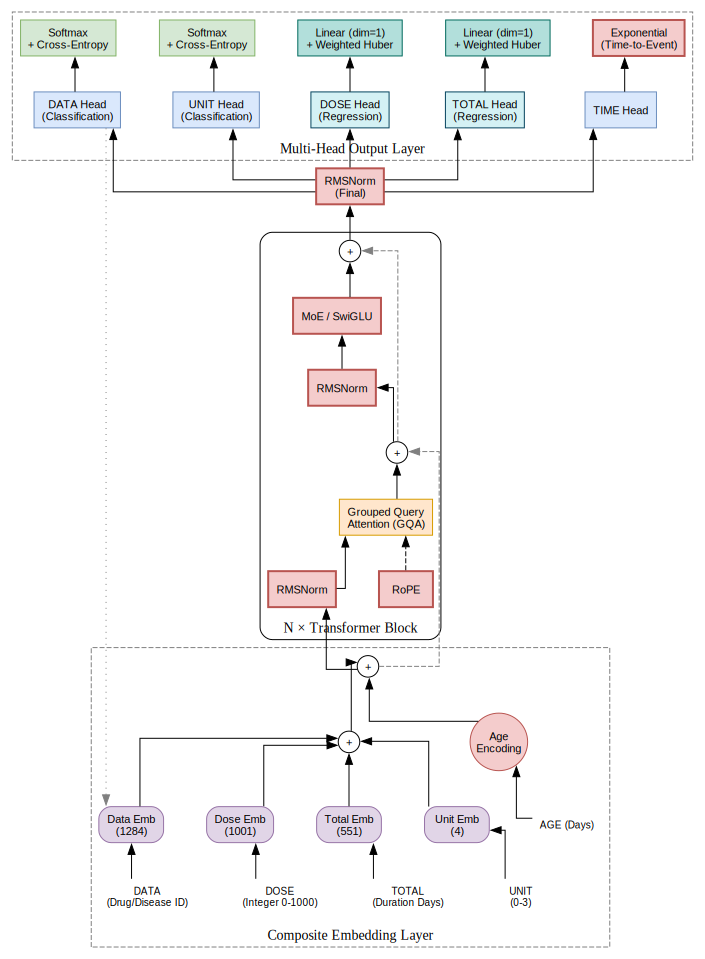

In [ ]:
from graphviz import Digraph

def draw_composite_delphi():
    """
    CompositeDelphi Architecture Diagram
    - DATA/UNIT: Classification (Softmax)
    - DOSE/TOTAL: Regression (Weighted Huber Loss)
    - TIME: Exponential (Time-to-Event)
    """
    dot = Digraph('CompositeDelphi', comment='CompositeDelphi: Multi-Head Output with Regression & Classification')
    dot.attr(rankdir='BT')  # Bottom to Top
    dot.attr(splines='ortho')
    dot.attr(nodesep='0.6', ranksep='0.5')
    dot.attr('node', fontname='Helvetica', fontsize='11')

    # 색상 팔레트
    COLOR_RED_FILL = '#F4CCCC'    # New/Special features (RoPE, RMSNorm, MoE)
    COLOR_RED_LINE = '#B85450'
    COLOR_BLUE_FILL = '#DAE8FC'   # Classification Heads
    COLOR_BLUE_LINE = '#6C8EBF'
    COLOR_CYAN_FILL = '#D4F1F4'   # Regression Heads (NEW)
    COLOR_CYAN_LINE = '#05445E'
    COLOR_ORANGE_FILL = '#FFE6CC' # Attention
    COLOR_ORANGE_LINE = '#D79B00'
    COLOR_GREEN_FILL = '#D5E8D4'  # Classification Outputs
    COLOR_GREEN_LINE = '#82B366'
    COLOR_TEAL_FILL = '#B2DFDB'   # Regression Outputs (NEW)
    COLOR_TEAL_LINE = '#00695C'
    COLOR_PURPLE_FILL = '#E1D5E7' # Embeddings
    COLOR_PURPLE_LINE = '#9673A6'

    # 노드 스타일 함수 정의
    def node_new(name, label):
        dot.node(name, label, shape='box', style='filled', fillcolor=COLOR_RED_FILL, color=COLOR_RED_LINE, penwidth='2.0')

    def node_cls_head(name, label):
        """Classification Head (DATA, UNIT)"""
        dot.node(name, label, shape='box', style='filled', fillcolor=COLOR_BLUE_FILL, color=COLOR_BLUE_LINE)

    def node_reg_head(name, label):
        """Regression Head (DOSE, TOTAL)"""
        dot.node(name, label, shape='box', style='filled', fillcolor=COLOR_CYAN_FILL, color=COLOR_CYAN_LINE)

    def node_emb(name, label):
        dot.node(name, label, shape='box', style='filled,rounded', fillcolor=COLOR_PURPLE_FILL, color=COLOR_PURPLE_LINE, width='0.9')

    def node_cls_out(name, label):
        """Classification Output"""
        dot.node(name, label, shape='box', style='filled', fillcolor=COLOR_GREEN_FILL, color=COLOR_GREEN_LINE)

    def node_reg_out(name, label):
        """Regression Output"""
        dot.node(name, label, shape='box', style='filled', fillcolor=COLOR_TEAL_FILL, color=COLOR_TEAL_LINE)

    # --- [1. Inputs & Composite Embeddings] ---
    with dot.subgraph(name='cluster_inputs') as c:
        c.attr(style='dashed', label='Composite Embedding Layer', color='gray')
        
        # Inputs
        c.node('In_Data', 'DATA\n(Drug/Disease ID)', shape='plaintext', fontsize='10')
        c.node('In_Dose', 'DOSE\n(Integer 0-1000)', shape='plaintext', fontsize='10')
        c.node('In_Total', 'TOTAL\n(Duration Days)', shape='plaintext', fontsize='10')
        c.node('In_Unit', 'UNIT\n(0-3)', shape='plaintext', fontsize='10')
        
        # Embeddings
        node_emb('Emb_Data', 'Data Emb\n(1284)')
        node_emb('Emb_Dose', 'Dose Emb\n(1001)')
        node_emb('Emb_Total', 'Total Emb\n(551)')
        node_emb('Emb_Unit', 'Unit Emb\n(4)')
        
        # Sum Operation
        c.node('Sum_Emb', '+', shape='circle', width='0.3', fixedsize='true', style='filled', fillcolor='white')
        
        # Age Encoding
        c.node('Times', 'AGE (Days)', shape='plaintext', fontsize='10')
        c.node('AgeEnc', 'Age\nEncoding', shape='circle', style='filled', fillcolor=COLOR_RED_FILL, color=COLOR_RED_LINE, width='0.8', fixedsize='true')
        
        # Final Combined Vector
        c.node('Sum_Final', '+', shape='circle', width='0.3', fixedsize='true')

        # Connections
        c.edge('In_Data', 'Emb_Data')
        c.edge('In_Dose', 'Emb_Dose')
        c.edge('In_Total', 'Emb_Total')
        c.edge('In_Unit', 'Emb_Unit')
        
        c.edge('Emb_Data', 'Sum_Emb')
        c.edge('Emb_Dose', 'Sum_Emb')
        c.edge('Emb_Total', 'Sum_Emb')
        c.edge('Emb_Unit', 'Sum_Emb')
        
        c.edge('Times', 'AgeEnc')
        c.edge('Sum_Emb', 'Sum_Final')
        c.edge('AgeEnc', 'Sum_Final')

    # --- [2. Main Transformer Block] ---
    with dot.subgraph(name='cluster_block') as c:
        c.attr(label='N × Transformer Block', style='rounded', color='black')
        
        node_new('RMS1', 'RMSNorm')
        
        # Attention part
        dot.node('GQA', 'Grouped Query\nAttention (GQA)', shape='box', style='filled', fillcolor=COLOR_ORANGE_FILL, color=COLOR_ORANGE_LINE)
        node_new('RoPE', 'RoPE')
        
        dot.node('Add1', '+', shape='circle', width='0.3', fixedsize='true')
        node_new('RMS2', 'RMSNorm')
        node_new('MoE', 'MoE / SwiGLU')
        dot.node('Add2', '+', shape='circle', width='0.3', fixedsize='true')

        # Internal Edges
        c.edge('RMS1', 'GQA')
        c.edge('RoPE', 'GQA', style='dashed')
        c.edge('GQA', 'Add1')
        c.edge('Add1', 'RMS2')
        c.edge('RMS2', 'MoE')
        c.edge('MoE', 'Add2')

    # --- [3. Multi-Head Outputs] ---
    with dot.subgraph(name='cluster_outputs') as c:
        c.attr(style='dashed', label='Multi-Head Output Layer', color='gray')
        
        # Final Norm before heads
        node_new('RMSFinal', 'RMSNorm\n(Final)')
        
        # Classification Heads (DATA, UNIT)
        node_cls_head('Head_Data', 'DATA Head\n(Classification)')
        node_cls_head('Head_Unit', 'UNIT Head\n(Classification)')
        
        # Regression Heads (DOSE, TOTAL)
        node_reg_head('Head_Dose', 'DOSE Head\n(Regression)')
        node_reg_head('Head_Total', 'TOTAL Head\n(Regression)')
        
        # Time Head
        node_cls_head('Head_Time', 'TIME Head')
        
        # Classification Outputs
        node_cls_out('Out_Data', 'Softmax\n+ Cross-Entropy')
        node_cls_out('Out_Unit', 'Softmax\n+ Cross-Entropy')
        
        # Regression Outputs
        node_reg_out('Out_Dose', 'Linear (dim=1)\n+ Weighted Huber')
        node_reg_out('Out_Total', 'Linear (dim=1)\n+ Weighted Huber')
        
        # Time Output
        node_new('Out_Time', 'Exponential\n(Time-to-Event)')

        # Head -> Output connections
        c.edge('Head_Data', 'Out_Data')
        c.edge('Head_Dose', 'Out_Dose')
        c.edge('Head_Total', 'Out_Total')
        c.edge('Head_Unit', 'Out_Unit')
        c.edge('Head_Time', 'Out_Time')

    # --- [Main Flow Connections] ---
    # Input to Block
    dot.edge('Sum_Final', 'RMS1')
    dot.edge('Sum_Final', 'Add1', style='dashed', color='gray')  # Skip connection
    dot.edge('Add1', 'Add2', style='dashed', color='gray')       # Skip connection
    
    # Block to Output Layer
    dot.edge('Add2', 'RMSFinal')
    
    # Distribute to Heads
    dot.edge('RMSFinal', 'Head_Data')
    dot.edge('RMSFinal', 'Head_Dose')
    dot.edge('RMSFinal', 'Head_Total')
    dot.edge('RMSFinal', 'Head_Unit')
    dot.edge('RMSFinal', 'Head_Time')
    
    # Weight Tying (DATA Head <-> Data Embedding)
    dot.edge('Head_Data', 'Emb_Data', style='dotted', color='gray', constraint='false')

    return dot

# 실행 및 출력
diagram = draw_composite_delphi()
display(diagram)